This script consumes Public Use Microdata Sample files (PUMS) files to create a merged, normalized file that can be used for analysis and answer specific queries about demographics in Seattle, specifically:

1. Number of residents living below Area Median Income (AMI) thresholds
2. Racial breakdown of People of Color living at 60% AMI in Seattle
3. Languages represented in the neighborhoods

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load data and filter for Seattle PUMS

data_dir = './data/'

# PUMS IDs for each selected PUMA (Seattle: Downtown, Northeast, Northwest, Southeast, and West)
SEATTLE_PUMS = [11601, 11602, 11603, 11604, 11605]

# Loading household data for Seattle-only locations
DF_HOUSEHOLD = pd.read_csv(data_dir + 'ss16hwa.csv')
DF_HOUSEHOLD = DF_HOUSEHOLD[DF_HOUSEHOLD['PUMA'].isin(SEATTLE_PUMS)]

# Loading person data for Seattle-only locations
DF_PERSON = pd.read_csv(data_dir + 'ss16pwa.csv')
DF_PERSON = DF_PERSON[DF_PERSON['PUMA'].isin(SEATTLE_PUMS)]

In [3]:
# Load AMI data tables. The Area median income thresholds are defined by HUD and a function of family size.
# Income limits are published here: 
# https://www.seattle.gov/Documents/Departments/Housing/PropertyManagers/IncomeRentLimits/2018%20Rent%20and%20Income%20Limits.pdf

df_AMI = pd.read_csv(data_dir + 'AMI_2016.csv')
df_40 = df_AMI[(df_AMI["Threshold"] == "40% AMI")]
df_50 = df_AMI[(df_AMI["Threshold"] == "50% AMI")]
df_60 = df_AMI[(df_AMI["Threshold"] == "60% AMI")]
df_80 = df_AMI[(df_AMI["Threshold"] == "80% AMI")]

## Process Person Data

In [4]:
# Filter the data set for important indices to track
DF_PERSON = DF_PERSON[['PUMA', 'SERIALNO', 'RAC1P', 'AGEP', 'DDRS', 'DEAR', 'DEYE',
                        'DOUT', 'DPHY', 'ENG', 'JWTR', 'JWRIP', 'LANX', 'PINCP', 'LANP', 'HISP']]

# Add text columns that correspond with race integers
DF_PERSON['race'] = np.where(DF_PERSON['RAC1P'] == 1, "White alone", "")
DF_PERSON['race'] = np.where(DF_PERSON['RAC1P'] == 2, "Black or African American alone", DF_PERSON['race'])
DF_PERSON['race'] = np.where(DF_PERSON['RAC1P'] == 3, "American Indian alone", DF_PERSON['race'])
DF_PERSON['race'] = np.where(DF_PERSON['RAC1P'] == 4, "Alaska Native alone", DF_PERSON['race'])
DF_PERSON['race'] = np.where(DF_PERSON['RAC1P'] == 5, "American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races", DF_PERSON['race'])
DF_PERSON['race'] = np.where(DF_PERSON['RAC1P'] == 6, "Asian alone", DF_PERSON['race'])
DF_PERSON['race'] = np.where(DF_PERSON['RAC1P'] == 7, "Native Hawaiian and Other Pacific Islander alone", DF_PERSON['race'])
DF_PERSON['race'] = np.where(DF_PERSON['RAC1P'] == 8, "Some Other Race alone", DF_PERSON['race'])
DF_PERSON['race'] = np.where(DF_PERSON['RAC1P'] == 9, "Two or More Races", DF_PERSON['race'])

# Add text columns that correspond with race integers
DF_PERSON['neighborhood'] = np.where(DF_PERSON['PUMA'] == 11601, "Northwest", "")
DF_PERSON['neighborhood'] = np.where(DF_PERSON['PUMA'] == 11602, "Northeast", DF_PERSON['neighborhood'])
DF_PERSON['neighborhood'] = np.where(DF_PERSON['PUMA'] == 11603, "Downtown, Queen Anne, Magnolia", DF_PERSON['neighborhood'])
DF_PERSON['neighborhood'] = np.where(DF_PERSON['PUMA'] == 11604, "Southeast, Capital Hill", DF_PERSON['neighborhood'])
DF_PERSON['neighborhood'] = np.where(DF_PERSON['PUMA'] == 11605, "West, Duwamish, Beacon Hill", DF_PERSON['neighborhood'])

# Add text columns that correspond with Hispanic origin/integers
DF_PERSON['hispanic'] = np.where(DF_PERSON['HISP'] == 1, "Not Spanish/Hispanic/Latino origin", "")
DF_PERSON['hispanic'] = np.where(DF_PERSON['HISP'] >= 2, "Spanish/Hispanic/Latino origin", DF_PERSON['hispanic'])

# Language text loaded from Codebook
# df_LANP = pd.read_csv(data_dir + 'Codebook_LANP.csv')
# DF_PERSON = pd.merge(left=DF_PERSON, right=df_LANP, how='left', left_on='LANP', right_on='LANP')
df_codebook = pd.read_csv(data_dir + 'Codebook.csv')
df_LANP = df_codebook[(df_codebook["Category"] == "LANP")]
DF_PERSON = pd.merge(left=DF_PERSON, right=df_LANP, how='left', left_on='LANP', right_on='Code')

## Process Household Data

In [5]:
# Filter the data set for important indices to track
DF_HOUSEHOLD = DF_HOUSEHOLD[['SERIALNO','HINCP','NP']]
                
# Filter for income > 1
DF_HOUSEHOLD = DF_HOUSEHOLD[(DF_HOUSEHOLD["HINCP"] > 1)]

# Escalate income to current year
# ref http://www.seattle.gov/financedepartment/cpi/documents/US_CPI_History_--_Annual.pdf
DF_HOUSEHOLD["HINCP"]  = DF_HOUSEHOLD["HINCP"] * 245.120 / 234.067
                        
# Limit very large households to 8 ppl to correspond with AMI tables
DF_HOUSEHOLD['NP'] = np.where(DF_HOUSEHOLD["NP"] > 8,8,DF_HOUSEHOLD['NP'])

NP_total = DF_HOUSEHOLD['NP'].sum()

# Add a new index for income below 60% of the median
# Add columns for number of people in each AMI threshold
DF_HOUSEHOLD = pd.merge(left=DF_HOUSEHOLD, right=df_80, how='left', left_on='NP', right_on='NP')
DF_HOUSEHOLD['AMI_80'] = np.where(DF_HOUSEHOLD['HINCP'] <= DF_HOUSEHOLD['Amount'], DF_HOUSEHOLD['NP'], 0)
DF_HOUSEHOLD = DF_HOUSEHOLD.drop(['Threshold', 'Amount'], axis=1)

DF_HOUSEHOLD = pd.merge(left=DF_HOUSEHOLD, right=df_60, how='left', left_on='NP', right_on='NP')
DF_HOUSEHOLD['HINCP_threshold'] = np.where(DF_HOUSEHOLD['HINCP'] <= DF_HOUSEHOLD['Amount'], "Under 60", "Over 60")
DF_HOUSEHOLD['AMI_60'] = np.where(DF_HOUSEHOLD['HINCP'] <= DF_HOUSEHOLD['Amount'], DF_HOUSEHOLD['NP'], 0)
DF_HOUSEHOLD = DF_HOUSEHOLD.drop(['Threshold', 'Amount'], axis=1)

DF_HOUSEHOLD = pd.merge(left=DF_HOUSEHOLD, right=df_50, how='left', left_on='NP', right_on='NP')
DF_HOUSEHOLD['AMI_50'] = np.where(DF_HOUSEHOLD['HINCP'] <= DF_HOUSEHOLD['Amount'], DF_HOUSEHOLD['NP'], 0)
DF_HOUSEHOLD = DF_HOUSEHOLD.drop(['Threshold', 'Amount'], axis=1)

DF_HOUSEHOLD = pd.merge(left=DF_HOUSEHOLD, right=df_40, how='left', left_on='NP', right_on='NP')
DF_HOUSEHOLD['AMI_40'] = np.where(DF_HOUSEHOLD['HINCP'] <= DF_HOUSEHOLD['Amount'], DF_HOUSEHOLD['NP'], 0)
DF_HOUSEHOLD = DF_HOUSEHOLD.drop(['Threshold', 'Amount'], axis=1)

DF_HOUSEHOLD = pd.merge(left=DF_HOUSEHOLD, right=df_40, how='left', left_on='NP', right_on='NP')
DF_HOUSEHOLD['AMI_40'] = np.where(DF_HOUSEHOLD['HINCP'] <= DF_HOUSEHOLD['Amount'], DF_HOUSEHOLD['NP'], 0)
DF_HOUSEHOLD = DF_HOUSEHOLD.drop(['Threshold', 'Amount'], axis=1)

# Calculate percentages for each household
HINCP_UNDER80 = DF_HOUSEHOLD['AMI_80'].sum() / NP_total
HINCP_UNDER60 = DF_HOUSEHOLD['AMI_60'].sum() / NP_total
HINCP_UNDER50 = DF_HOUSEHOLD['AMI_50'].sum() / NP_total
HINCP_UNDER40 = DF_HOUSEHOLD['AMI_40'].sum() / NP_total

print("Number of Seattle residents living at-")
print("80% AMI:", "{:.0%}".format(HINCP_UNDER80))
print("60% AMI:", "{:.0%}".format(HINCP_UNDER60))
print("50% AMI:", "{:.0%}".format(HINCP_UNDER50))
print("40% AMI:", "{:.0%}".format(HINCP_UNDER40))


#print (, HINCP_UNDER60, HINCP_UNDER50, HINCP_UNDER40)

Number of Seattle residents living at-
80% AMI: 29%
60% AMI: 20%
50% AMI: 16%
40% AMI: 13%


## Merged Household and Person Data

In [6]:
# Merge data set
DF_MERGED = pd.DataFrame()
DF_MERGED = pd.merge(left=DF_PERSON, right=DF_HOUSEHOLD, how='left', left_on='SERIALNO', right_on='SERIALNO')
DF_MERGED.to_csv(data_dir + 'PUMS_merged.csv', mode='w', header=True, index=False)

# Create classification for households under 60% AMI and POC
DF_MERGED = DF_MERGED[DF_MERGED["HINCP_threshold"] == "Under 60"]
DF_MERGED = DF_MERGED[DF_MERGED["race"] != "White alone"]

# Under 60% aggregated by race, calculate percentages of total, save as csv
DF_AGGREGATED_RACE = pd.DataFrame()
DF_AGGREGATED_RACE = DF_MERGED.groupby(['race'], as_index=False).agg({'NP':[sum]})
NP_TOTAL = DF_AGGREGATED_RACE['NP'].sum()
DF_AGGREGATED_RACE["pct"] = DF_AGGREGATED_RACE["NP"] / NP_TOTAL
DF_AGGREGATED_RACE.columns = DF_AGGREGATED_RACE.columns.droplevel(level=1)
DF_AGGREGATED_RACE.to_csv(data_dir + 'Aggregated_race.csv', mode='w', header=True, index=False)

# Under 60% aggregated by Hispanic/spanish/latino orgin, calculate percentages of total, save as csv
DF_AGGREGATED_HISPANIC_ORIGIN = pd.DataFrame()
DF_AGGREGATED_HISPANIC_ORIGIN = DF_MERGED.groupby(['hispanic'], as_index=False).agg({'NP':[sum]})
NP_TOTAL = DF_AGGREGATED_HISPANIC_ORIGIN['NP'].sum()
DF_AGGREGATED_HISPANIC_ORIGIN["pct"] = DF_AGGREGATED_HISPANIC_ORIGIN["NP"] / NP_TOTAL
DF_AGGREGATED_HISPANIC_ORIGIN.columns = DF_AGGREGATED_HISPANIC_ORIGIN.columns.droplevel(level=1)
DF_AGGREGATED_HISPANIC_ORIGIN.to_csv(data_dir + 'AGGREGATED_HISPANIC_ORIGIN.csv', mode='w', header=True, index=False)

# Aggregate by race and neighborhood, calculate percentage of total, save as csv
DF_AGGREGATED_RACE_NEIGHB = pd.DataFrame()
DF_AGGREGATED_RACE_NEIGHB = DF_MERGED.groupby(['neighborhood', 'race'], as_index=False).agg({'NP':[sum]})
DF_AGGREGATED_RACE_NEIGHB.columns = DF_AGGREGATED_RACE_NEIGHB.columns.droplevel(level=1)
NP_TOTAL = DF_AGGREGATED_RACE_NEIGHB['NP'].sum()
DF_AGGREGATED_RACE_NEIGHB["pct"] = DF_AGGREGATED_RACE_NEIGHB["NP"] / NP_TOTAL
DF_AGGREGATED_RACE_NEIGHB.to_csv(data_dir + 'Aggregated_race_neighb.csv', mode='w', header=True, index=False)

# Aggregate by language and neighborhood, calulate percentages, save as csv
DF_AGGREGATED_LANG_NEIGHB = pd.DataFrame()
DF_AGGREGATED_LANG_NEIGHB = DF_MERGED.groupby(['neighborhood','Description'], as_index=False).agg({'NP':['sum']})
DF_AGGREGATED_LANG_NEIGHB.columns = DF_AGGREGATED_LANG_NEIGHB.columns.droplevel(level=1)
NP_TOTAL = DF_AGGREGATED_LANG_NEIGHB['NP'].sum()
DF_AGGREGATED_LANG_NEIGHB["pct"] = DF_AGGREGATED_LANG_NEIGHB["NP"] / NP_TOTAL
DF_AGGREGATED_LANG_NEIGHB.to_csv(data_dir + 'Aggregated_lang_neighb.csv', mode='w', header=True, index=False)

print("Racial breakdown of People of Color living at 60% AMI in Seattle")
print(DF_AGGREGATED_RACE)

print("Racial breakdown of Spanish/Hispanic/Latio origin living at 60% AMI in Seattle")
print(DF_AGGREGATED_HISPANIC_ORIGIN)

print("Further breakdown: What geographic neighborhoods are represented in this data")
print(DF_AGGREGATED_RACE_NEIGHB)

print("Languages represented in the neighborhoods")
print(DF_AGGREGATED_LANG_NEIGHB)

Racial breakdown of People of Color living at 60% AMI in Seattle
                                                race     NP       pct
0                              American Indian alone    7.0  0.004232
1  American Indian and Alaska Native tribes speci...    1.0  0.000605
2                                        Asian alone  635.0  0.383918
3                    Black or African American alone  615.0  0.371826
4   Native Hawaiian and Other Pacific Islander alone   29.0  0.017533
5                              Some Other Race alone   72.0  0.043531
6                                  Two or More Races  295.0  0.178356
Racial breakdown of Spanish/Hispanic/Latio origin living at 60% AMI in Seattle
                             hispanic      NP       pct
0  Not Spanish/Hispanic/Latino origin  1559.0  0.942563
1      Spanish/Hispanic/Latino origin    95.0  0.057437
Further breakdown: What geographic neighborhoods are represented in this data
                      neighborhood  \
0   Downtown

## Language Word Cloud

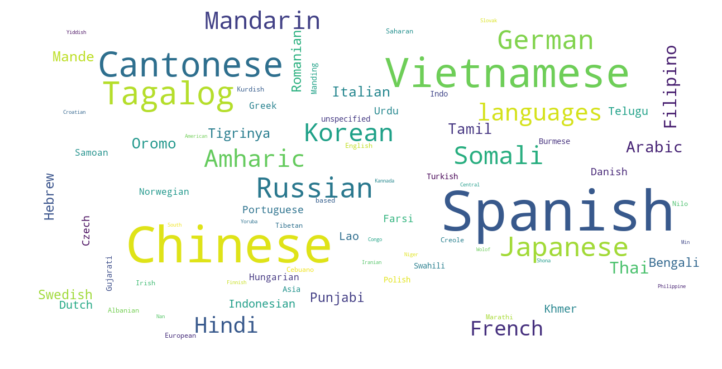

In [8]:
def wordCloud(Text):

    # Sudo pip install wordcloud
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    import numpy as np
    from PIL import Image
    from os import path
    import matplotlib.pyplot as plt
    import random

    # Shape masked wordcloud
    # Mask = np.array(Image.open("./Data/Tweets/map.jpg"))
    # Image_colors = ImageColorGenerator(mask)

    # text wordcloud
    # Wordcloud = WordCloud(max_font_size=100, width = 1200, height = 600, mode = 'RGBA', background_color = 'white').generate(' '.join(Text))
    wordcloud = WordCloud(collocations=False, max_font_size=100, width =1200, height =600, mode ='RGBA', background_color ='white').generate(' '.join(Text))
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    wordcloud.to_file("./Data/PUMS_Languages.png")

Languages = DF_PERSON['Description'].tolist()
Languages = [x for x in Languages if str(x) != 'nan']
Languages = [x for x in Languages if str(x) != 'Nan']

wordCloud(Languages)